In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime as dt
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
from sklearn.metrics import mean_squared_error
import gc
from pathlib import Path

# DATA_PATH = "../input/ashrae-energy-prediction/"
DATA_PATH = Path(r"C:\Users\evilp\project\competition\Kaggle-ASHRAE\data")

def compress(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def log_func(func):
    def _wrapper(*args, **kwargs):
        print(f"start {func.__name__} ...")
        start = dt.datetime.now()
        result = func(*args, **kwargs)
        print(f"finish  {func.__name__},  cost {dt.datetime.now() - start}")
        return result
    return _wrapper

# data
@log_func
def load_data(data_root_path):
    train_df = pd.read_csv(data_root_path / "train.csv", parse_dates=['timestamp'])
    test_df = pd.read_csv(data_root_path / 'test.csv', parse_dates=['timestamp'])
    weather_train = pd.read_csv(data_root_path / "weather_train.csv", parse_dates=['timestamp'])
    weather_test = pd.read_csv(data_root_path / "weather_test.csv", parse_dates=['timestamp'])
    building_meta = pd.read_csv(data_root_path / "building_metadata.csv")
    return train_df, test_df, weather_train, weather_test, building_meta


def feature_engineering(x):
    categorical_features = ['building_id', 'meter', 'site_id', 'primary_use', 'hour', 'weekend']
    # sort values by building_id timestamp?
    x["hour"] = x["timestamp"].dt.hour
    x["weekend"] = x["timestamp"].dt.weekday

    drop = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed", "year_built", "floor_count"]
    x = x.drop(drop, axis=1)
    gc.collect()
    return x, categorical_features

def kfold_train(model_params, features, target, n_splits, categorical_features, seed):
    kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    models = []
    cv_scores = []
    for train_index, test_index in kf.split(features):
        train_features = features.loc[train_index]
        train_target = target.loc[train_index]

        test_features = features.loc[test_index]
        test_target = target.loc[test_index]

        d_training = lgb.Dataset(train_features, label=train_target, categorical_feature=categorical_features,
                                 free_raw_data=False)
        d_test = lgb.Dataset(test_features, label=test_target, categorical_feature=categorical_features,
                             free_raw_data=False)

        model = lgb.train(model_params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training, d_test],
                          verbose_eval=25, early_stopping_rounds=50)
        score = np.sqrt(mean_squared_error(test_target, model.predict(test_features, num_iteration=model.best_iteration)))
        models.append(model)
        cv_scores.append(score)
        # del train_features, train_target, test_features, test_target, d_training, d_test
        # gc.collect()

    print(f'cv score: {np.mean(cv_scores)}')
    return models, cv_scores

In [ ]:
train_df, test_df, weather_train, weather_test, building_meta = load_data(DATA_PATH)

start load_data ...


In [ ]:
weather = pd.concat([weather_train, weather_test]).reset_index(drop=True)

In [ ]:
def process_meta(x):
    le = LabelEncoder().fit(x.primary_use)
    x['primary_use'] = le.transform(x['primary_use'])
    
    x['square_feet'] = np.log1p(x['square_feet'])
    x['year_built'] = 2016 - x['year_built'] + 1
    return x


def process_weather(x):
    return x

In [ ]:
building_meta = process_meta(building_meta)

In [ ]:
# train_target = np.log1p(train_df.meter_reading)
# train_df.drop('meter_reading', axis=1, inplace=True)
# row_id = test_df.row_id
# test_df.drop('row_id', axis=1, inplace=True)

In [ ]:
train_df = train_df.merge(building_meta, on='building_id').merge(weather, on=['site_id', 'timestamp'])

In [ ]:
train_df = compress(train_df)

In [ ]:
train_features, categorical_features = feature_engineering(train_df)

In [ ]:
train_features

In [ ]:
features = train_features.drop('meter_reading', axis=1)
target = np.log1p(train_features.meter_reading)


In [ ]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

In [ ]:
models = kfold_train(params,features,target, 3, categorical_features, 42)

In [83]:
models[1]

[5.1143564396645065, 4.381525430131702, 4.3740558774956355]

In [84]:
feature_engineering

<function __main__.feature_engineering(x)>

In [85]:
train_target

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
              ...   
20216095    2.277267
20216096    1.762159
20216097    0.000000
20216098    5.078761
20216099    1.348073
Name: meter_reading, Length: 20216100, dtype: float64

In [88]:
def plot_importance(models):
    for model in models:
        lgb.plot_importance(model)
        plt.show()

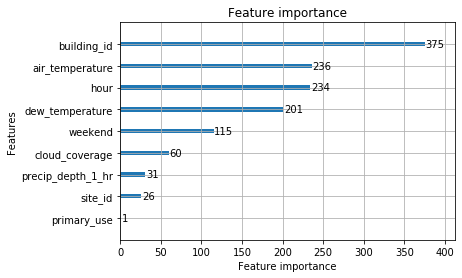

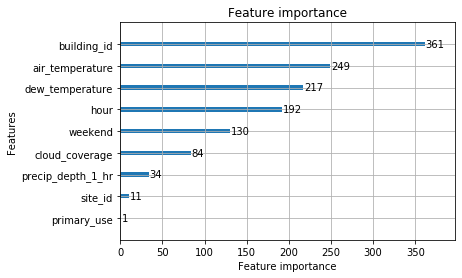

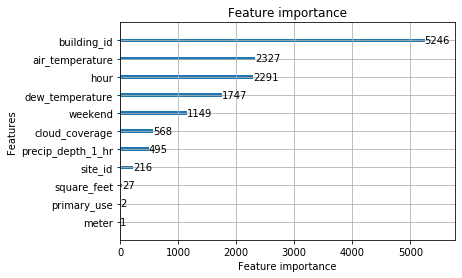

In [90]:
plot_importance(models[0])